Reference: https://www.tensorflow.org/hub/tutorials/object_detection

# Libraries and paths

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

# Para el acceso a los ficheros
import os
# Para las imágenes
import numpy as np
import cv2 # OpenCV-Python
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
# Para controlar el tiempo
import time

In [ ]:
images_path = "../../Report/Images"

In [2]:
data_path = "../../Circuito_Almeria_171021/Iniciados/Data_resized_5/"

# Functions

In [3]:
def calculateIntersection(a0, a1, b0, b1):
    """
    Calcula la intersección entre el conjunto [a0, a1] y el conjunto [b0, b1].
    Reference: https://stackoverflow.com/questions/48477130/find-area-of-overlapping-rectangles-in-python-cv2-with-a-raw-list-of-points

    Parameters:
        a0(float32): inicio del primer conjunto
        a1(float32): final del primer conjunto
        b0(float32): inicio del segundo conjunto
        b1(float32): final del segundo conjunto

    Returns:
        (float32): Valor de la longitud de la intersección
    """
    if a0 >= b0 and a1 <= b1:  # Contained
        intersection = a1 - a0
    elif a0 < b0 and a1 > b1:  # Contains
        intersection = b1 - b0
    elif a0 < b0 and a1 > b0:  # Intersects right
        intersection = a1 - b0
    elif a1 > b1 and a0 < b1:  # Intersects left
        intersection = b1 - a0
    else:  # No intersection (either side)
        intersection = 0

    return intersection

def apply_detection(converted_img, detector_):
    result = detector_(converted_img)
    result = {key:value.numpy() for key,value in result.items()}
    return result

def detect_motorcycles(object_detection_result, architecture = "mobilenet"):
    if architecture == "mobilenet":
        class_column = "detection_classes"
        motorcycle_class = 4
    elif architecture == "inception":
        class_column = "detection_class_labels"
        motorcycle_class = 300
    else:
        print("Elige una arquitectura de las siguientes: mobilenet, inception.")
        return None
    return pd.DataFrame(np.concatenate((object_detection_result["detection_boxes"][object_detection_result[class_column] == motorcycle_class],
                                        np.reshape(object_detection_result["detection_scores"][object_detection_result[class_column] == motorcycle_class].T, (np.sum(object_detection_result[class_column] == motorcycle_class),1))), axis=1), columns = ["ymin", "xmin", "ymax", "xmax", "score"])

## FASE BETA GAMMA ETTA
def detect_people(object_detection_result, architecture = "mobilenet"):
    if architecture == "mobilenet":
        class_column = "detection_classes"
        person_class = 1
    elif architecture == "inception":
        class_column = "detection_class_labels"
        person_class = 69
    else:
        print("Elige una arquitectura de las siguientes: mobilenet, inception.")
        return None
    return pd.DataFrame(np.concatenate((object_detection_result["detection_boxes"][object_detection_result[class_column] == person_class],
                                        np.reshape(object_detection_result["detection_scores"][object_detection_result[class_column] == person_class].T, (np.sum(object_detection_result[class_column] == person_class),1))), axis=1), columns = ["ymin", "xmin", "ymax", "xmax", "score"])

def remove_little_score(boxes_and_scores, threshold = 0.5):
    return boxes_and_scores[boxes_and_scores.score > threshold]

def remove_overlaying(boxes_and_scores, threshold = 0.5):
    boxes_and_scores = boxes_and_scores.assign(area = (boxes_and_scores["ymax"]-boxes_and_scores["ymin"])*(boxes_and_scores["xmax"]-boxes_and_scores["xmin"])).sort_values("score", ascending = False).reset_index()
    for idx in range(len(boxes_and_scores)):
        for i in range(idx):
            if i in boxes_and_scores.index:
                width = calculateIntersection(boxes_and_scores.loc[idx, "xmin"], boxes_and_scores.loc[idx, "xmax"],
                                              boxes_and_scores.loc[i, "xmin"], boxes_and_scores.loc[i, "xmax"])
                height = calculateIntersection(boxes_and_scores.loc[idx, "ymin"], boxes_and_scores.loc[idx, "ymax"],
                                              boxes_and_scores.loc[i, "ymin"], boxes_and_scores.loc[i, "ymax"])
                # SE CALCULA Y SE GUARDA EL AREA DE LA INTERSECCIÓN
                area_interseccion = width * height
                # SE CALCULA EL PORCENTAJE DE AREA QUE INTERSECTA Y SE ELIMINA LA FILA SI ES MAYOR QUE UN UMBRAL
                if area_interseccion/min(boxes_and_scores.loc[idx, "area"], boxes_and_scores.loc[i, "area"]) > threshold:
                    boxes_and_scores = boxes_and_scores.drop(idx)
                    break
    return boxes_and_scores.reset_index()

def draw_boxes_and_scores(img, boxes_and_scores):
    for row in range(len(boxes_and_scores)):
        ymin, xmin, ymax, xmax, score = boxes_and_scores.loc[row, ["ymin", "xmin", "ymax", "xmax", "score"]]
        im_height, im_width = img.shape[0:2]
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                    ymin * im_height, ymax * im_height)
        cv2.line(img, (int(left), int(top)), (int(left), int(bottom)), (0,0,0))
        cv2.line(img, (int(left), int(top)), (int(right), int(top)), (0,0,0))
        cv2.line(img, (int(right), int(top)), (int(right), int(bottom)), (0,0,0))
        cv2.line(img, (int(right), int(bottom)), (int(left), int(bottom)), (0,0,0))
        cv2.putText(img, str(round(score,3)), (int(left), int(top)), cv2.FONT_HERSHEY_COMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

def extract_boxes(img, boxes_and_scores):
    im_height, im_width = img.shape[0:2]
    img_boxes = []
    for row in boxes_and_scores.index:
        ymin, xmin, ymax, xmax = boxes_and_scores.loc[row, ["ymin", "xmin", "ymax", "xmax"]]
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)
        img_boxes.append(img_dos_motos[int(top):int(bottom), int(left):int(right), :])
    return img_boxes

# Load pretrained modules

In [4]:
module_handle = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"
detector_mobilenet = hub.load(module_handle).signatures['serving_default']

In [5]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector_inception = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# Demo

## First image

### Load image

In [6]:
images_path = "../../Report/Images"

In [7]:
img = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[5])

### Architecture: SSD Mobilenet_v2, Dataset: COCO2017

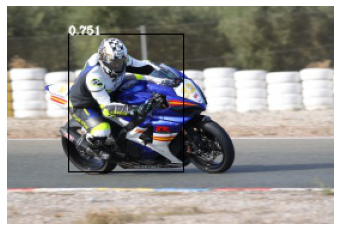

In [8]:
converted_img = tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...]
result = apply_detection(converted_img, detector_mobilenet)
boxes_and_scores = detect_people(result, architecture="mobilenet")
boxes_and_scores = remove_little_score(boxes_and_scores)
boxes_and_scores = remove_overlaying(boxes_and_scores)
img = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[5])
for row in range(len(boxes_and_scores)):
    ymin, xmin, ymax, xmax, score = boxes_and_scores.loc[row, ["ymin", "xmin", "ymax", "xmax", "score"]]
    im_height, im_width = img.shape[0:2]
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    cv2.line(img, (int(left), int(top)), (int(left), int(bottom)), (0,0,0))
    cv2.line(img, (int(left), int(top)), (int(right), int(top)), (0,0,0))
    cv2.line(img, (int(right), int(top)), (int(right), int(bottom)), (0,0,0))
    cv2.line(img, (int(right), int(bottom)), (int(left), int(bottom)), (0,0,0))
    cv2.putText(img, str(round(score,3)), (int(left), int(top)), cv2.FONT_HERSHEY_COMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.savefig("../../Report/Images/explicacion_od_2.jpg", dpi=300, bbox_inches="tight")
plt.show()

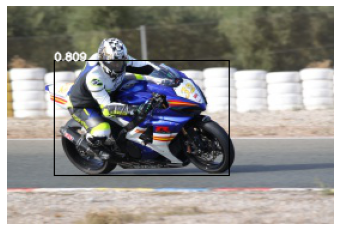

In [9]:
converted_img = tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...]
result = apply_detection(converted_img, detector_mobilenet)
boxes_and_scores = detect_motorcycles(result, architecture="mobilenet")
boxes_and_scores = remove_little_score(boxes_and_scores)
boxes_and_scores = remove_overlaying(boxes_and_scores)
img = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[5])
for row in range(len(boxes_and_scores)):
    ymin, xmin, ymax, xmax, score = boxes_and_scores.loc[row, ["ymin", "xmin", "ymax", "xmax", "score"]]
    im_height, im_width = img.shape[0:2]
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    cv2.line(img, (int(left), int(top)), (int(left), int(bottom)), (0,0,0))
    cv2.line(img, (int(left), int(top)), (int(right), int(top)), (0,0,0))
    cv2.line(img, (int(right), int(top)), (int(right), int(bottom)), (0,0,0))
    cv2.line(img, (int(right), int(bottom)), (int(left), int(bottom)), (0,0,0))
    cv2.putText(img, str(round(score,3)), (int(left), int(top)), cv2.FONT_HERSHEY_COMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.savefig("../../Report/Images/explicacion_od_3.jpg", dpi=300, bbox_inches="tight")
plt.show()

### Architecture: Faster R-CNN, Dataset: OpenImagesV4

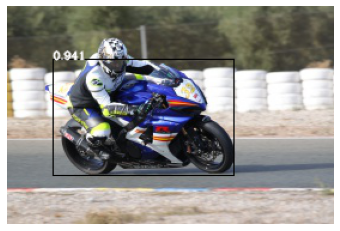

In [11]:
converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
result = apply_detection(converted_img, detector_inception)
boxes_and_scores = detect_motorcycles(result, architecture="inception")
boxes_and_scores = remove_little_score(boxes_and_scores)
boxes_and_scores = remove_overlaying(boxes_and_scores)
img = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[5])
draw_boxes_and_scores(img, boxes_and_scores)

## Second image
In this case the other side of the same motorcycle will be tested

### Load image

In [12]:
img_2 = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[14])

### Architecture: SSD Mobilenet_v2, Dataset: COCO2017

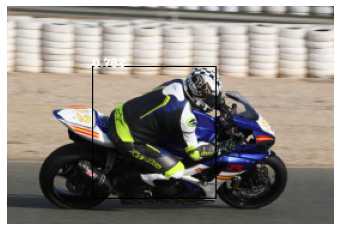

In [13]:
converted_img = tf.image.convert_image_dtype(img_2, tf.uint8)[tf.newaxis, ...]
result = apply_detection(converted_img, detector_mobilenet)
boxes_and_scores = detect_people(result, architecture="mobilenet")
boxes_and_scores = remove_little_score(boxes_and_scores)
boxes_and_scores = remove_overlaying(boxes_and_scores)
img_2 = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[14])
draw_boxes_and_scores(img_2, boxes_and_scores)

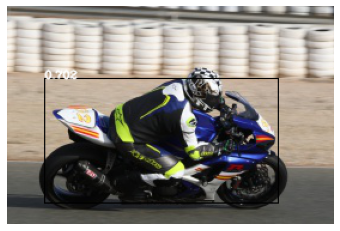

In [14]:
converted_img = tf.image.convert_image_dtype(img_2, tf.uint8)[tf.newaxis, ...]
result = apply_detection(converted_img, detector_mobilenet)
boxes_and_scores = detect_motorcycles(result, architecture="mobilenet")
boxes_and_scores = remove_little_score(boxes_and_scores)
boxes_and_scores = remove_overlaying(boxes_and_scores)
img_2 = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[14])
draw_boxes_and_scores(img_2, boxes_and_scores)

### Architecture: Faster R-CNN, Dataset: OpenImagesV4

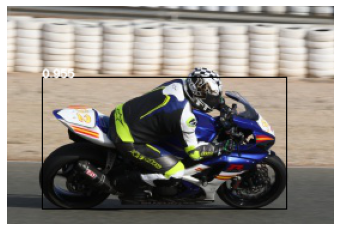

In [15]:
converted_img = tf.image.convert_image_dtype(img_2, tf.float32)[tf.newaxis, ...]
result = apply_detection(converted_img, detector_inception)
boxes_and_scores = detect_motorcycles(result, architecture="inception")
boxes_and_scores = remove_little_score(boxes_and_scores)
boxes_and_scores = remove_overlaying(boxes_and_scores)
img_2 = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[14])
draw_boxes_and_scores(img_2, boxes_and_scores)

## Third image
In this case a photo with two motocycles will be tested

### Load image

In [16]:
img_dos_motos = cv2.imread(data_path + "19" + "/" + "CI0A7765.JPG")

### Architecture: SSD Mobilenet_v2, Dataset: COCO2017

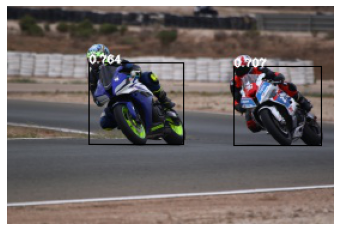

In [17]:
converted_img = tf.image.convert_image_dtype(img_dos_motos, tf.uint8)[tf.newaxis, ...]
result = apply_detection(converted_img, detector_mobilenet)
boxes_and_scores = detect_motorcycles(result, architecture="mobilenet")
boxes_and_scores = remove_little_score(boxes_and_scores)
boxes_and_scores = remove_overlaying(boxes_and_scores)
img_dos_motos = cv2.imread(data_path + "19" + "/" + "CI0A7765.JPG")
draw_boxes_and_scores(img_dos_motos, boxes_and_scores)

### Architecture: Faster R-CNN, Dataset: OpenImagesV4

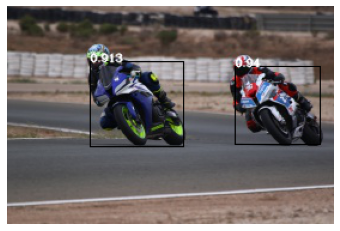

In [18]:
converted_img = tf.image.convert_image_dtype(img_dos_motos, tf.float32)[tf.newaxis, ...]
result = apply_detection(converted_img, detector_inception)
boxes_and_scores = detect_motorcycles(result, architecture="inception")
boxes_and_scores = remove_little_score(boxes_and_scores, 0.3) #The threshold needs to be lower as sometimes the algorithm fails to detect the red and blue motorcycle with bigger than 0.5 score
boxes_and_scores = remove_overlaying(boxes_and_scores)
img_dos_motos = cv2.imread(data_path + "19" + "/" + "CI0A7765.JPG")
draw_boxes_and_scores(img_dos_motos, boxes_and_scores)

TODO
* Filtrar boxes en función de si comparten más de un tanto por ciento con otras. Hecho!!
* Testear si de esta manera se puede saber cuántas motos salen en cada imagen a través de un experimento en el que se tienen diferentes clases según el número de motos que aparecen y se infieren cuantas motos detecta el algoritmo. Hecho!!
* Que extraiga también al piloto (person)

# Extract motorcycle(s) independently

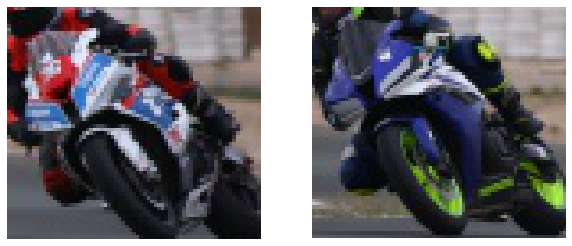

In [19]:
fig, axes = plt.subplots(1, len(boxes_and_scores), figsize=(5*len(boxes_and_scores), 5))
im_height, im_width = img_dos_motos.shape[0:2]
img_dos_motos = cv2.imread(data_path + "19" + "/" + "CI0A7765.JPG")
img_boxes = extract_boxes(img_dos_motos, boxes_and_scores)
for i,box in enumerate(img_boxes):
    axes[i].imshow(cv2.cvtColor(box, cv2.COLOR_BGR2RGB))
    axes[i].axis("off")

## Experiment to prove that this algorithm can determine how many motorcycles there are

## MobileNet

## Resized_5

In [20]:
data_experiment_path = "../../Circuito_Almeria_171021/Iniciados/Data_number_of_motorcycles/"

In [21]:
lista = []
for folder in os.listdir(data_experiment_path):
    for file in os.listdir(os.path.join(data_experiment_path,folder)):
        img = cv2.imread(os.path.join(data_experiment_path,folder,file))
        converted_img = tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...]
        result = apply_detection(converted_img, detector_mobilenet)
        boxes_and_scores = detect_motorcycles(result, architecture="mobilenet")
        boxes_and_scores = remove_little_score(boxes_and_scores)
        boxes_and_scores = remove_overlaying(boxes_and_scores)
        lista.append([os.path.join(data_experiment_path,folder,file), boxes_and_scores, int(folder), len(boxes_and_scores)])

In [22]:
nb_of_motorcycles_experiment = pd.DataFrame(lista, columns = ["path", "boxes_and_scores", "number_of_motorcycles_real", "number_of_motorcycles_detected"])

In [23]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(nb_of_motorcycles_experiment.number_of_motorcycles_real,
                              nb_of_motorcycles_experiment.number_of_motorcycles_detected)).rename(columns = {0:"1_detected" ,1:"2_detected", 2:"3_detected"},index = {0:"1" ,1:"2", 2:"3"})

,1_detected,2_detected,3_detected
1,65,0,0
2,5,24,0
3,1,3,1


In [24]:
nb_of_motorcycles_experiment_wrong = nb_of_motorcycles_experiment[nb_of_motorcycles_experiment.number_of_motorcycles_real != nb_of_motorcycles_experiment.number_of_motorcycles_detected]

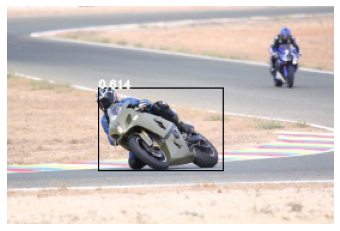

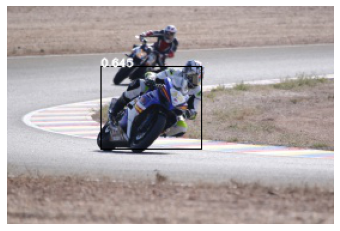

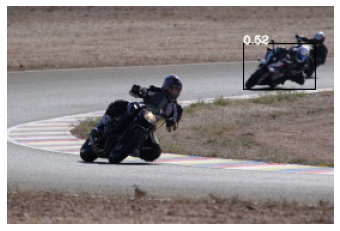

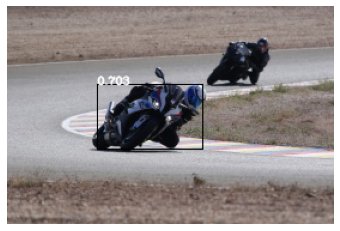

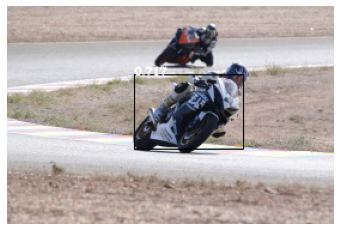

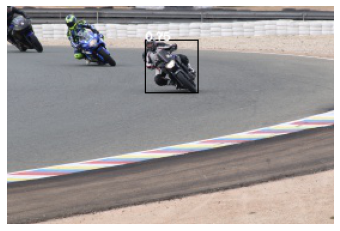

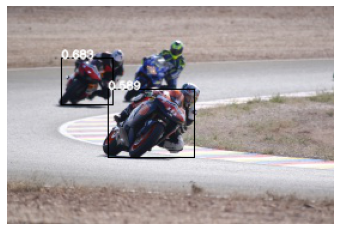

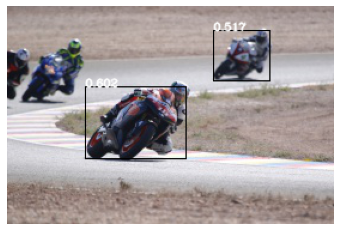

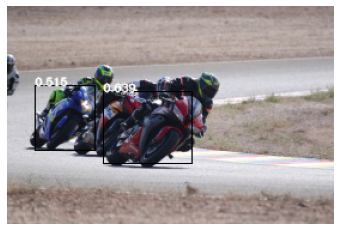

In [25]:
for row in nb_of_motorcycles_experiment_wrong.index:
    img_wrong = cv2.imread(nb_of_motorcycles_experiment_wrong.loc[row, "path"])
    draw_boxes_and_scores(img_wrong, nb_of_motorcycles_experiment_wrong.loc[row, "boxes_and_scores"])

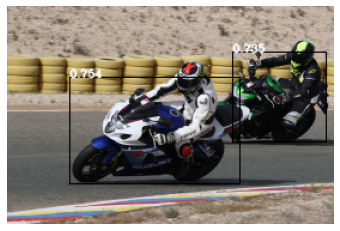

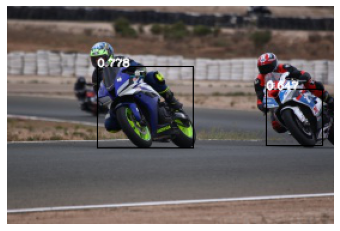

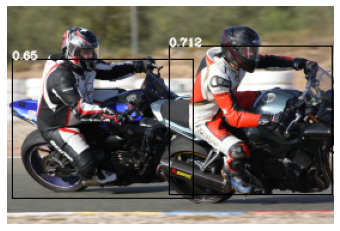

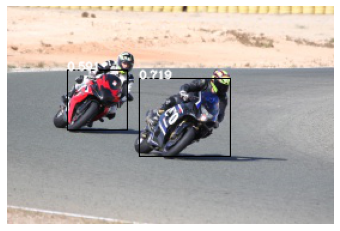

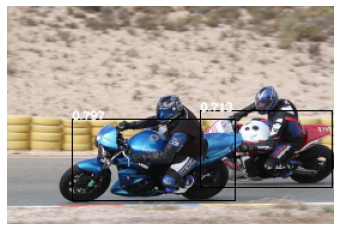

In [26]:
nb_of_motorcycles_experiment_two = nb_of_motorcycles_experiment[(nb_of_motorcycles_experiment.number_of_motorcycles_real == 2) & (nb_of_motorcycles_experiment.number_of_motorcycles_detected == 2)]
for row in nb_of_motorcycles_experiment_two.sample(5, random_state=42).index:
    img_two = cv2.imread(nb_of_motorcycles_experiment_two.loc[row, "path"])
    draw_boxes_and_scores(img_two, nb_of_motorcycles_experiment_two.loc[row, "boxes_and_scores"])

## Resized_10

In [27]:
data_experiment_path = "../../Circuito_Almeria_171021/Iniciados/Data_number_of_motorcycles_10/"

In [28]:
lista = []
for folder in os.listdir(data_experiment_path):
    for file in os.listdir(os.path.join(data_experiment_path,folder)):
        img = cv2.imread(os.path.join(data_experiment_path,folder,file))
        converted_img = tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...]
        result = apply_detection(converted_img, detector_mobilenet)
        boxes_and_scores = detect_motorcycles(result, architecture="mobilenet")
        boxes_and_scores = remove_little_score(boxes_and_scores)
        boxes_and_scores = remove_overlaying(boxes_and_scores)
        lista.append([os.path.join(data_experiment_path,folder,file), boxes_and_scores, int(folder), len(boxes_and_scores)])

In [29]:
nb_of_motorcycles_experiment = pd.DataFrame(lista, columns = ["path", "boxes_and_scores", "number_of_motorcycles_real", "number_of_motorcycles_detected"])

In [30]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(nb_of_motorcycles_experiment.number_of_motorcycles_real,
                              nb_of_motorcycles_experiment.number_of_motorcycles_detected)).rename(columns = {0:"1_detected" ,1:"2_detected", 2:"3_detected"},index = {0:"1" ,1:"2", 2:"3"})

,1_detected,2_detected,3_detected
1,65,0,0
2,6,23,0
3,1,3,1


## Inception

## Resized_5

In [31]:
data_experiment_path = "../../Circuito_Almeria_171021/Iniciados/Data_number_of_motorcycles/"

In [32]:
lista = []
for folder in os.listdir(data_experiment_path):
    for file in os.listdir(os.path.join(data_experiment_path,folder)):
        img = cv2.imread(os.path.join(data_experiment_path,folder,file))
        converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
        result = apply_detection(converted_img, detector_inception)
        boxes_and_scores = detect_motorcycles(result, architecture="inception")
        boxes_and_scores = remove_little_score(boxes_and_scores)
        boxes_and_scores = remove_overlaying(boxes_and_scores)
        lista.append([os.path.join(data_experiment_path,folder,file), boxes_and_scores, int(folder), len(boxes_and_scores)])

In [33]:
nb_of_motorcycles_experiment = pd.DataFrame(lista, columns = ["path", "boxes_and_scores", "number_of_motorcycles_real", "number_of_motorcycles_detected"])

In [34]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(nb_of_motorcycles_experiment.number_of_motorcycles_real,
                              nb_of_motorcycles_experiment.number_of_motorcycles_detected)).rename(columns = {0:"1_detected" ,1:"2_detected", 2:"3_detected"},index = {0:"1" ,1:"2", 2:"3"})

,1_detected,2_detected,3_detected
1,65,0,0
2,6,23,0
3,2,2,1


## Resized_10

In [35]:
data_experiment_path = "../../Circuito_Almeria_171021/Iniciados/Data_number_of_motorcycles_10/"

In [36]:
lista = []
for folder in os.listdir(data_experiment_path):
    for file in os.listdir(os.path.join(data_experiment_path,folder)):
        img = cv2.imread(os.path.join(data_experiment_path,folder,file))
        converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
        result = apply_detection(converted_img, detector_inception)
        boxes_and_scores = detect_motorcycles(result, architecture="inception")
        boxes_and_scores = remove_little_score(boxes_and_scores)
        boxes_and_scores = remove_overlaying(boxes_and_scores)
        lista.append([os.path.join(data_experiment_path,folder,file), boxes_and_scores, int(folder), len(boxes_and_scores)])

In [37]:
nb_of_motorcycles_experiment = pd.DataFrame(lista, columns = ["path", "boxes_and_scores", "number_of_motorcycles_real", "number_of_motorcycles_detected"])

In [38]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(nb_of_motorcycles_experiment.number_of_motorcycles_real,
                              nb_of_motorcycles_experiment.number_of_motorcycles_detected)).rename(columns = {0:"1_detected" ,1:"2_detected", 2:"3_detected"},index = {0:"1" ,1:"2", 2:"3"})

,1_detected,2_detected,3_detected
1,65,0,0
2,5,24,0
3,0,3,2


### Compare timings

### MobileNet

In [39]:
def all_object_detection_mobilenet(image):
    converted_img = tf.image.convert_image_dtype(image, tf.uint8)[tf.newaxis, ...]
    result = apply_detection(converted_img, detector_mobilenet)
    boxes_and_scores = detect_motorcycles(result, architecture="mobilenet")
    boxes_and_scores = remove_little_score(boxes_and_scores)
    boxes_and_scores = remove_overlaying(boxes_and_scores)

In [40]:
data_path = "../../Circuito_Almeria_171021/Iniciados/Data_resized_5/"
img = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[5])

In [41]:
%timeit all_object_detection_mobilenet(img)

134 ms ± 636 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
data_path = "../../Circuito_Almeria_171021/Iniciados/Data_resized_10/"
img = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[5])

In [43]:
%timeit all_object_detection_mobilenet(img)

135 ms ± 780 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
data_path = "../../Circuito_Almeria_171021/Iniciados/Data_resized_25/"
img = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[5])

In [45]:
%timeit all_object_detection_mobilenet(img)

139 ms ± 454 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
data_path = "../../Circuito_Almeria_171021/Iniciados/Data_resized_33/"
img = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[5])

In [47]:
%timeit all_object_detection_mobilenet(img)

150 ms ± 597 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
data_path = "../../Circuito_Almeria_171021/Iniciados/Data_resized_50/"
img = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[5])

In [49]:
%timeit all_object_detection_mobilenet(img)

157 ms ± 983 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1]:
mobilenet_times = [0.134, 0.135, 0.139, 0.150, 0.157]

### Inception

In [50]:
def all_object_detection_inception(image):
    converted_img = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]
    result = apply_detection(converted_img, detector_inception)
    boxes_and_scores = detect_motorcycles(result, architecture="inception")
    boxes_and_scores = remove_little_score(boxes_and_scores)
    boxes_and_scores = remove_overlaying(boxes_and_scores)

In [51]:
data_path = "../../Circuito_Almeria_171021/Iniciados/Data_resized_5/"
img = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[5])

In [52]:
%timeit all_object_detection_inception(img)

In [53]:
data_path = "../../Circuito_Almeria_171021/Iniciados/Data_resized_10/"
img = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[5])

In [54]:
%timeit all_object_detection_inception(img)

17.1 s ± 255 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
data_path = "../../Circuito_Almeria_171021/Iniciados/Data_resized_25/"
img = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[5])

In [56]:
%timeit all_object_detection_inception(img)

17.1 s ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
data_path = "../../Circuito_Almeria_171021/Iniciados/Data_resized_33/"
img = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[5])

In [58]:
%timeit all_object_detection_inception(img)

17.1 s ± 48.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
data_path = "../../Circuito_Almeria_171021/Iniciados/Data_resized_50/"
img = cv2.imread(data_path + "1" + "/" + os.listdir(data_path + os.listdir(data_path)[0])[5])

In [60]:
%timeit all_object_detection_inception(img)

17.1 s ± 41.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
inception_times = [17.1, 17.1, 17.1, 17.1, 17.1]

In [11]:
mobilenet_times = [0.134, 0.135, 0.139, 0.150, 0.157]

In [12]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)

In [13]:
scales = [5,10,25,33,50]

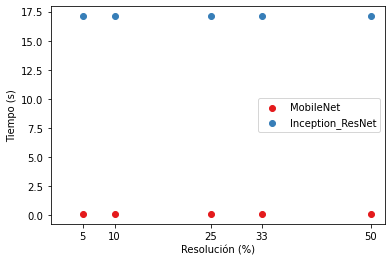

In [15]:
plt.scatter(scales, mobilenet_times)
plt.scatter(scales, inception_times)
plt.xlabel("Resolución (%)")
plt.xlim(0)
plt.xticks(scales)
plt.ylabel("Tiempo (s)")
plt.legend(["MobileNet", "Inception_ResNet"])
plt.savefig(images_path + "/tiempo_mobilenetvsinception.jpg", dpi=300, bbox_inches="tight")
plt.show()